# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Ingrese su nombre y apellido

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from math import *
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir datasets de dígitos (train, test)

In [2]:
# Digits Test
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
# Digits Train
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-26 04:35:47--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt.2’

1_digits_test.txt.2 100%[===================>] 183.20K  --.-KB/s    in 0.03s   

2023-10-26 04:35:47 (5.24 MB/s) - ‘1_digits_test.txt.2’ saved [187595/187595]

--2023-10-26 04:35:47--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

## Leer dataset de dígitos

In [3]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [4]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [5]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [6]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [7]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-7-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-7-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-7-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [8]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [9]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [10]:
#@title Funcion auxiliar para crear modelos mas amigable y productiva.
def model_def(activation, layers, device):
    functs = []

    functs.append(nn.Linear(layers[0], layers[1]))
    functs.append(activation)

    for i in range(1, len(layers) - 2):
        functs.append(nn.Linear(layers[i], layers[i + 1]))
        functs.append(activation)

    functs.append(nn.Linear(layers[-2], layers[-1]))

    return nn.Sequential(*functs).to(device)

model_def(nn.ReLU(), [64, 10, 10], torch.device('cuda'))


Sequential(
  (0): Linear(in_features=64, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

In [11]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [12]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

labels_set = {'0' : [True, True, False],
          '1' : labels_train,
          '2' : labels_val,
          '3' : labels_test}

In [13]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

dataloaders_list = [dataloader_train,
               dataloader_val,
               dataloader_test]

# Comienzo desarrollo tarea 2.

### Pregunta 2

## Entrenamiento

In [14]:
#@title PLOT METHOD && RELATED TO

import matplotlib.pyplot as plt

def plotMODELTRAINING(epochs, loss_train, loss_val):
  # Graficar loss de entrenamiento Y validación
  plt.figure(figsize = (8, 5))
  plt.title('Model loss on train & validation')
  plt.xlabel('dt')
  plt.ylabel('Loss')
  plt.plot(epochs, loss_train, 'b', label = 'Train')
  plt.plot(epochs, loss_val, 'r', label = 'Validation')
  plt.grid()
  plt.legend()
  plt.show()

In [15]:
#@title PLOT FOR CONFUSION MATRIX
def plot4ConfMatrix(conf_matrix, tipo, accuracy):
  import seaborn
  plt.figure(figsize=(8, 6))
  seaborn.heatmap(conf_matrix, annot=True, cmap='crest', cbar=False)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'CONF MATRIX {tipo.upper()} ACCURACY {accuracy:.4f}')
  plt.show()

In [16]:
#@title MODEL RESET
def reset_model(model):
    for layer in model.modules():
        if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
            # Reinitialize the weights and biases
            layer.reset_parameters()

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

class results:
  def __init__(self, name, model, optimizer, loss_train, epochs, time, accuracies, predictions, confusion_matrix):
    self.name = name
    self.model = model
    self.optimizer = optimizer
    self.loss_train = loss_train
    self.epochs = epochs
    self.time = time
    self.accuracies = accuracies
    self.predictions = predictions
    self.confusion_matrix = confusion_matrix

def training(name, model, optimizer, epoch, criterion, device, labels_set, dataloaders):
  """
  labels: {0: [bool, bool, bool], 1 : label_train, 2 : label_val, 3: label_test}
  dataloaders: [dataloader_train, ...val, ...test]
  """
  start = time.time()

  # Guardar resultados del loss y epocas que duró el entrenamiento
  loss_train = []
  loss_val = []
  epochs = []

  # Resultados locales
  _accuracies = dict()
  _predictions = dict()
  _confusion_matrixs = dict()

  # For labels
  lb_booleans = labels_set['0']
  label_names = ['entrenamiento', 'validacion', 'test']


  # EARLY STOPIN'
  last_loss_val = 999999
  patience = 15
  wait = 0

  # Entrenamiento de la red por n epocas
  for e in range(epoch):

    # Guardar loss de cada batch
    loss_train_batches = []
    loss_val_batches = []

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)           # Predicciones
      loss = criterion(outputs, labels) # Loss de entrenamiento
      loss.backward()                   # Backpropagation
      optimizer.step()

      # Guardamos la pérdida de entrenamiento en el batch actual
      loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

    # Predicción en conjunto de validación ---------------------------------------
    model.eval()
    with torch.no_grad():
      # Iteramos dataloader_val para evaluar el modelo en los datos de validación
      for i, data in enumerate(dataloader_val, 0):
        # Procesar batch actual
        inputs = data["features"].to(device) # Características
        labels = data["labels"].to(device)   # Clases

        outputs = model(inputs)             # Obtenemos predicciones

        # Guardamos la pérdida de validación en el batch actual
        loss = criterion(outputs, labels)
        loss_val_batches.append(loss.item())

    # Guardamos el Loss de validación de la época actual
    loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

    # Guardamos la época
    epochs.append(e)

    # Imprimir la pérdida de entrenamiento/validación en la época actual

    if((loss_val[e] - last_loss_val) < 0): # Se llega a el primer mejor resultado
      last_loss_val = loss_val[e]
      wait = 0
    else:
      wait +=1
      if(wait >= patience):
          print("SE ME ACABO LA PACIENCIA D:<")
          print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(e, loss_train[e], loss_val[e])))
          break

  end = time.time()
  print('Finished Training, total time %f seconds' % (end - start))

  plotMODELTRAINING(np.linspace(0, (end - start), len(loss_train)), loss_train, loss_val)
  print("\n")

  # Confusion Matrix producer ----------------------------------------------------
  for j, h in enumerate(lb_booleans):
    if(h):
      model.eval()
      with torch.no_grad():
        # Obtenemos label correspondiente
        current_label = labels_set[f'{j+1}']
        current_predictions = []

        for i, data in enumerate(dataloaders_list[j], 0):

          # Procesar batch actual
          inputs = data["features"].to(device) # Características
          labels = data["labels"].to(device)   # Clases

          _, predictions = torch.max(model(inputs), 1)

          # Guardamos labels y predicciones
          #current_label.extend(labels.cpu().numpy())
          current_predictions.extend(predictions.cpu().numpy())

        # Accuracy
        current_accuracy = accuracy_score(current_label, current_predictions, normalize=True)

        # Current confusion Matrix
        current_confusion_matrix = confusion_matrix(current_label, current_predictions, normalize='true')

        plot4ConfMatrix(current_confusion_matrix, label_names[j], current_accuracy)
        print("\n")

        _accuracies[label_names[j]] = current_accuracy
        _predictions[label_names[j]] = current_predictions
        _confusion_matrixs[label_names[j]] = current_confusion_matrix

  return results(name, model, optimizer, loss_train, epochs, end-start,  _accuracies, _predictions, _confusion_matrixs)

In [18]:
#@title RESULTS COMPILATION
resultados = []

SE ME ACABO LA PACIENCIA D:<
Epoch: 135, train loss: 0.0385, val loss: 0.1389
Finished Training, total time 16.961299 seconds


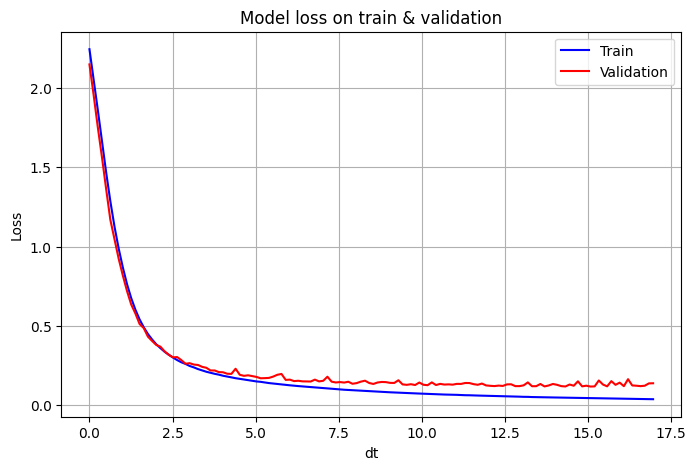

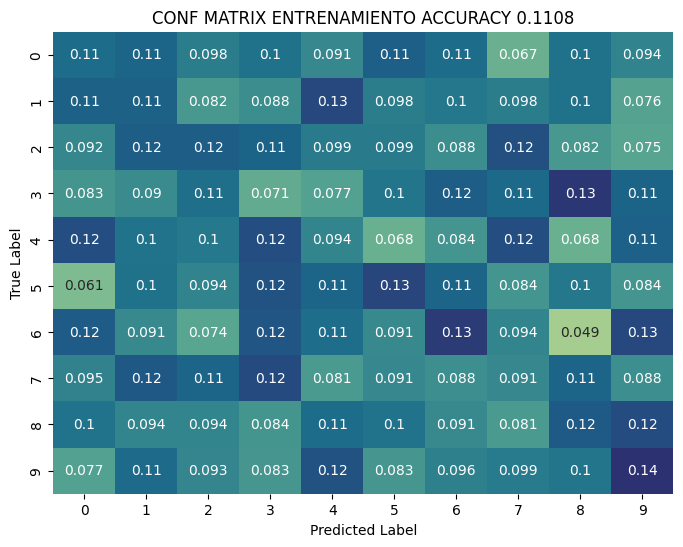

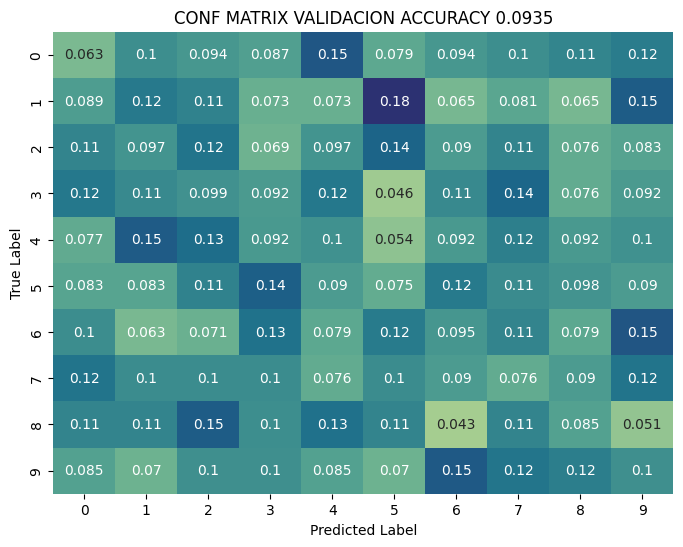

In [19]:
#@title 10 Neuronas en la capa oculta, ReLU y 1000 epocas como maximo.
model10HReLU = model_def(nn.ReLU(), [64, 10, 10], device)

resultados.append(training('resultados10HReLU', model10HReLU,
                             torch.optim.Adam(model10HReLU.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list))

SE ME ACABO LA PACIENCIA D:<
Epoch: 95, train loss: 0.0062, val loss: 0.0679
Finished Training, total time 6.188835 seconds


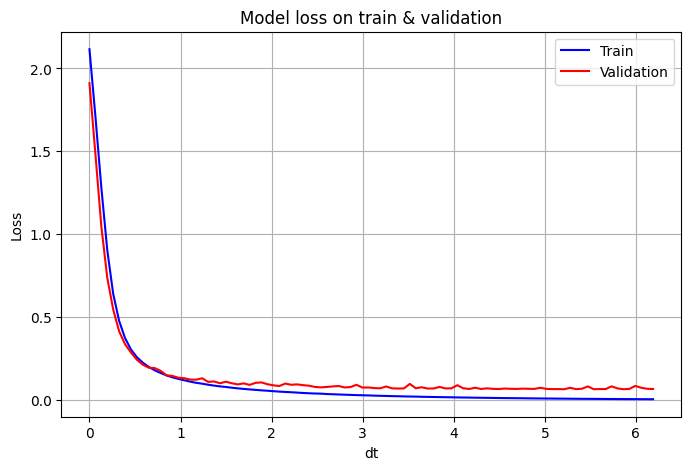

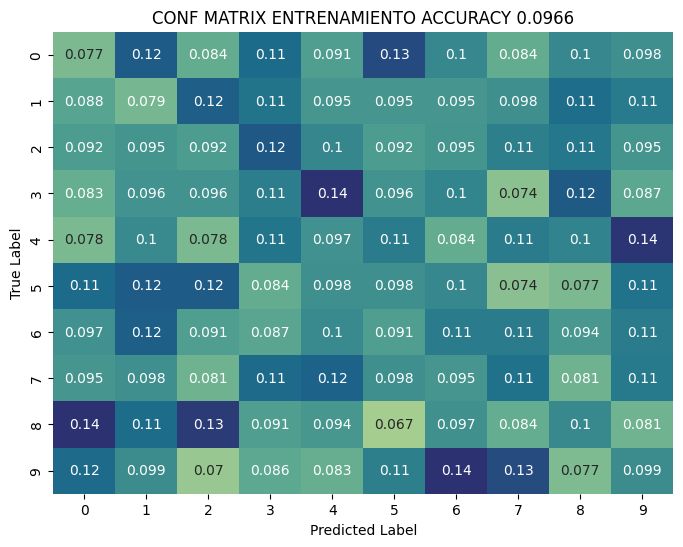

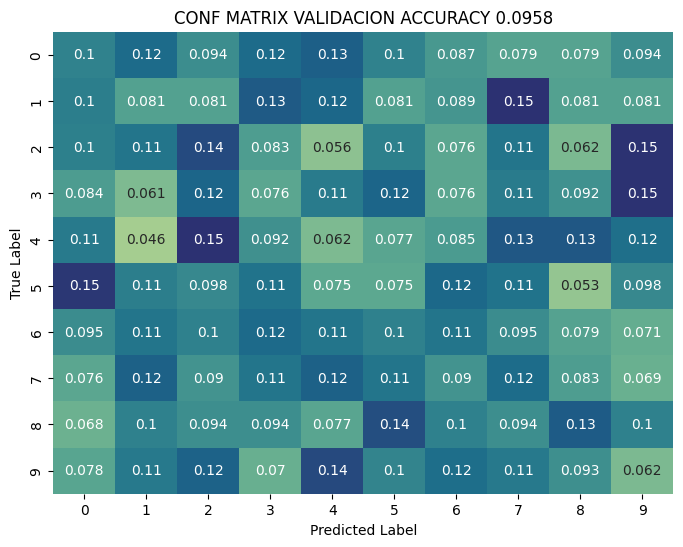

In [20]:
#@title 40 neuronas capa oculta, ReLU y 1000 epocas como maximo.
model40HReLU = model_def(nn.ReLU(), [64, 40, 10], device)

resultados.append(training('resultados40HReLU', model40HReLU,
                             torch.optim.Adam(model40HReLU.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list))

SE ME ACABO LA PACIENCIA D:<
Epoch: 141, train loss: 0.0496, val loss: 0.1327
Finished Training, total time 8.653939 seconds


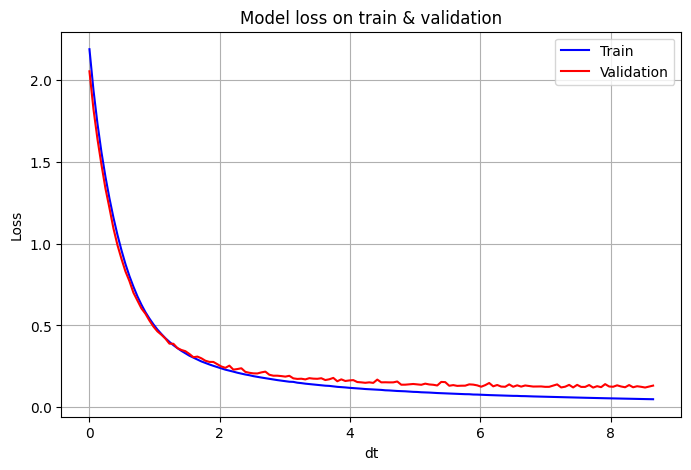

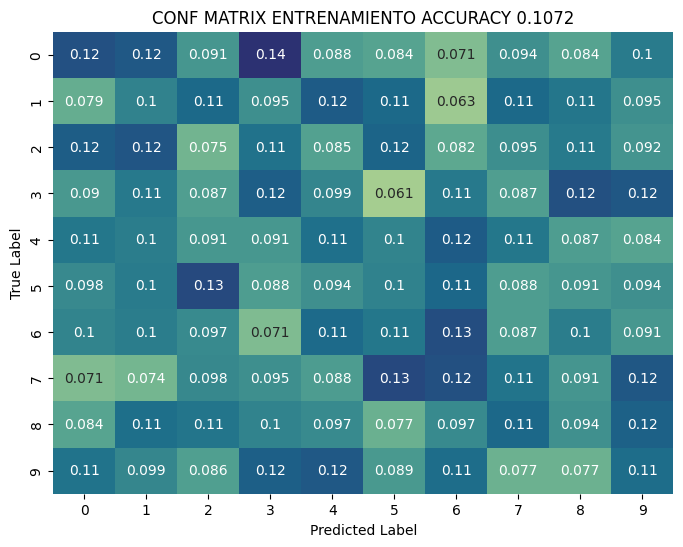

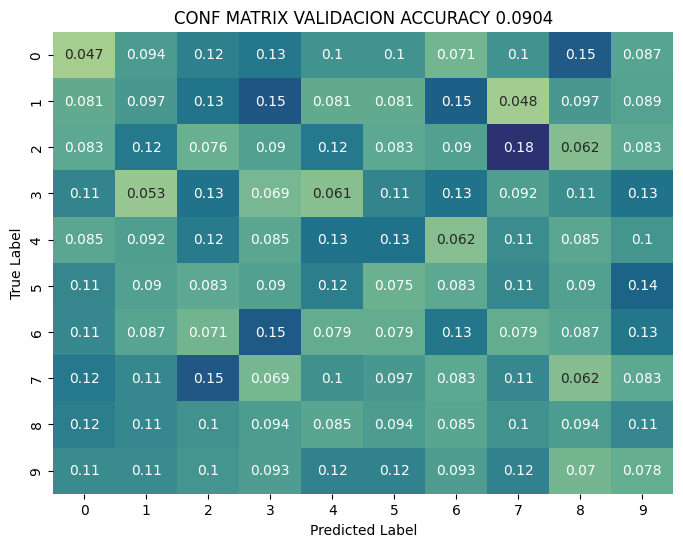

In [21]:
#@title 10 neuronas capa oculta, Tanh y 1000 epocas como maximo.
model10HTanh = model_def(nn.Tanh(), [64, 10, 10], device)

resultados.append(training('resultados10HTanh', model10HTanh,
                             torch.optim.Adam(model10HTanh.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list))

SE ME ACABO LA PACIENCIA D:<
Epoch: 142, train loss: 0.0050, val loss: 0.0785
Finished Training, total time 8.175225 seconds


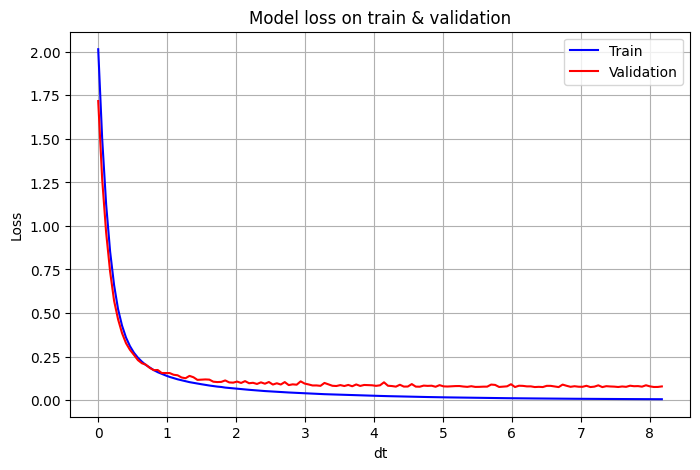

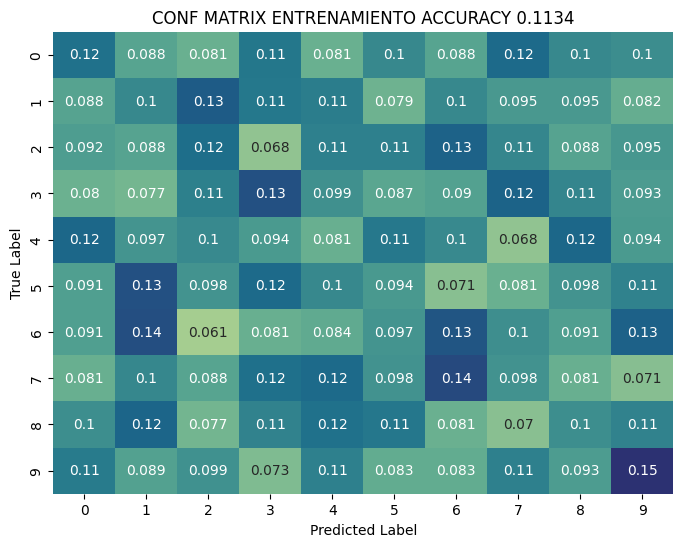

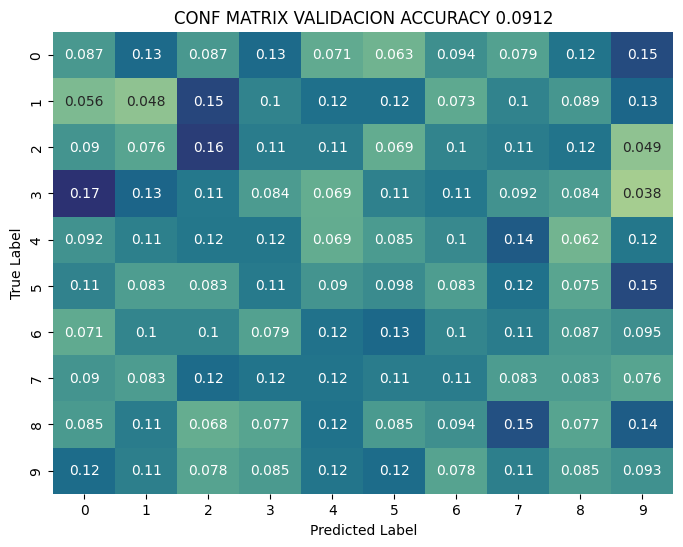

In [22]:
#@title 40 neuronas capa oculta, Tanh y 1000 epocas como maximo.
model40HTanh = model_def(nn.Tanh(), [64, 40, 10], device)

resultados.append(training('resultados40HTanh', model40HTanh,
                             torch.optim.Adam(model40HTanh.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list))

SE ME ACABO LA PACIENCIA D:<
Epoch: 75, train loss: 0.0478, val loss: 0.1480
Finished Training, total time 5.022896 seconds


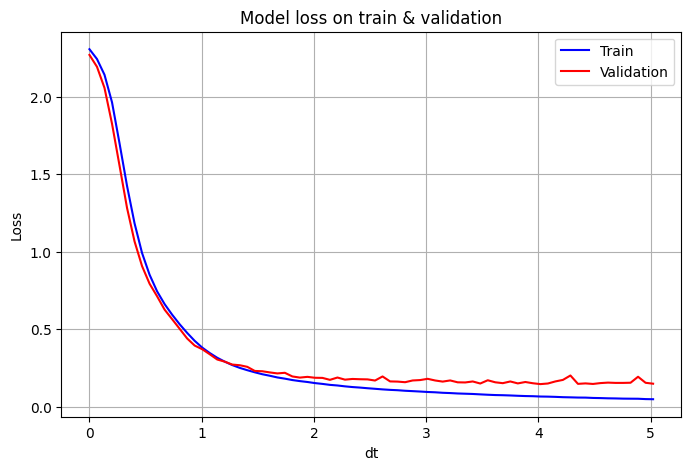

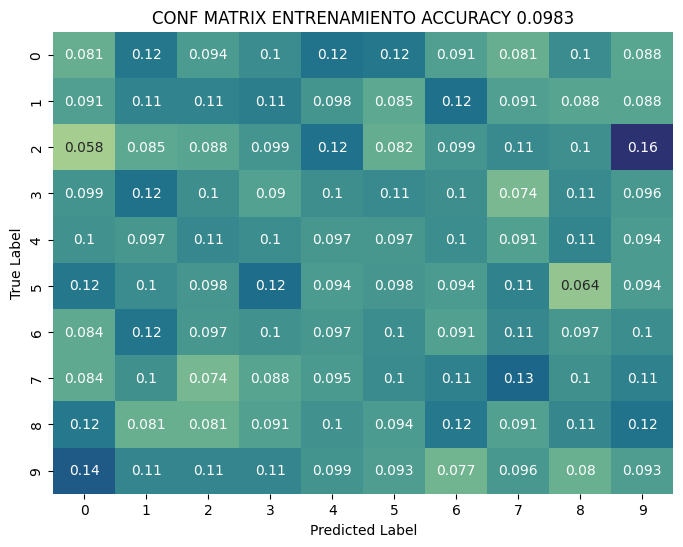

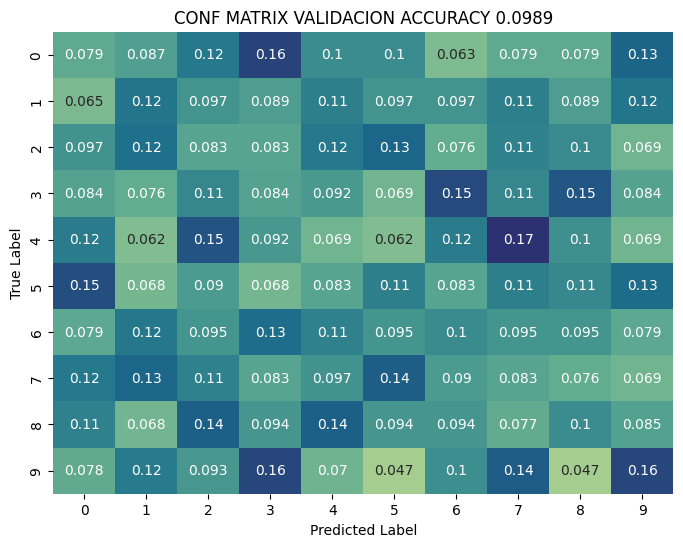

In [23]:
#@title 10 Neuronas en 2 capas ocultas, ReLU y 1000 epocas como maximo.
model210HReLU = model_def(nn.ReLU(), [64, 10, 10, 10], device)

resultados.append(training('resultados210HReLU', model210HReLU,
                             torch.optim.Adam(model210HReLU.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list))

SE ME ACABO LA PACIENCIA D:<
Epoch: 46, train loss: 0.0073, val loss: 0.0900
Finished Training, total time 2.903460 seconds


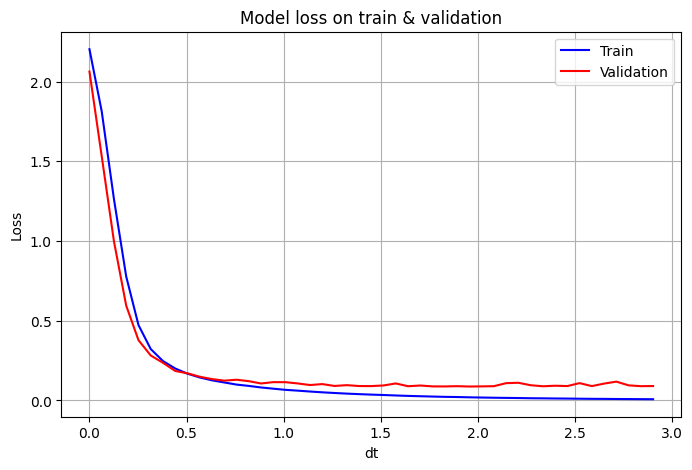

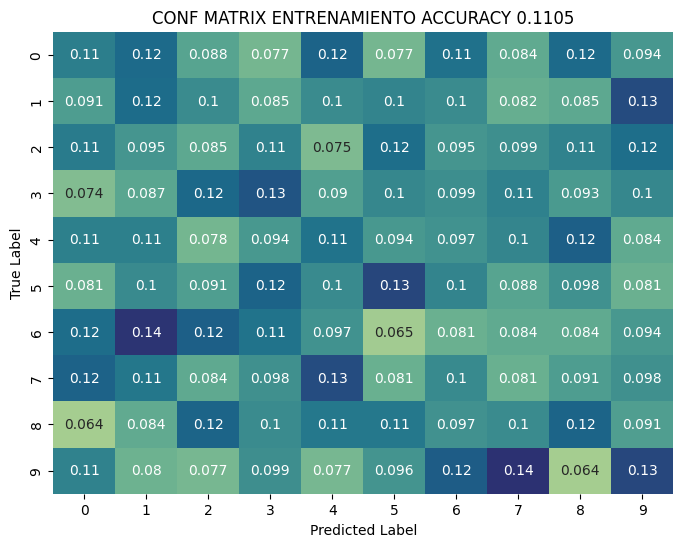

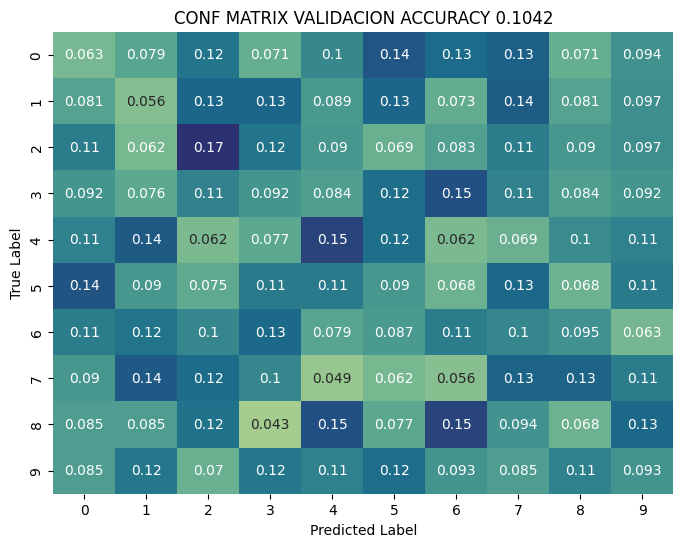

In [24]:
#@title 40 Neuronas en 2 capas ocultas, ReLU y 1000 epocas como maximo.
model240HReLU = model_def(nn.ReLU(), [64, 40, 40, 10], device)

resultados.append(training('resultados240HReLU', model240HReLU,
                             torch.optim.Adam(model240HReLU.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list))

## P3
Usando la mejor red encontrada en validacion (aquella con mayor accuracy en validacion), calcular la matriz de confusion normalizada y el accuracy normalizado, usando el conjunto de prueba.

resultados240HReLU
RESET MODEL STARTED
GETTING TEST LABELS PLOTS
SE ME ACABO LA PACIENCIA D:<
Epoch: 47, train loss: 0.0076, val loss: 0.0829
Finished Training, total time 3.636591 seconds


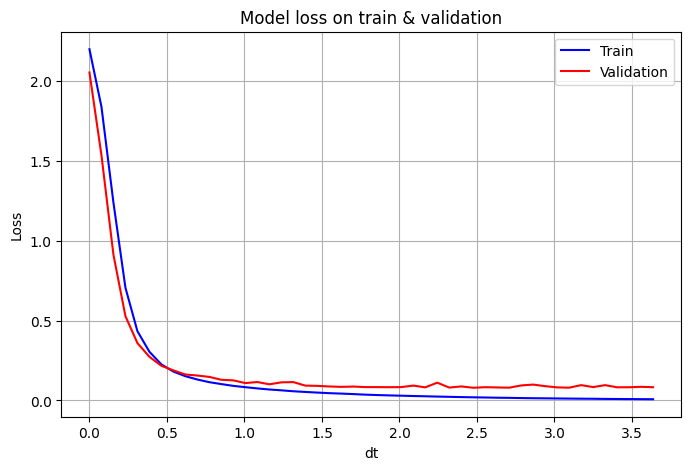

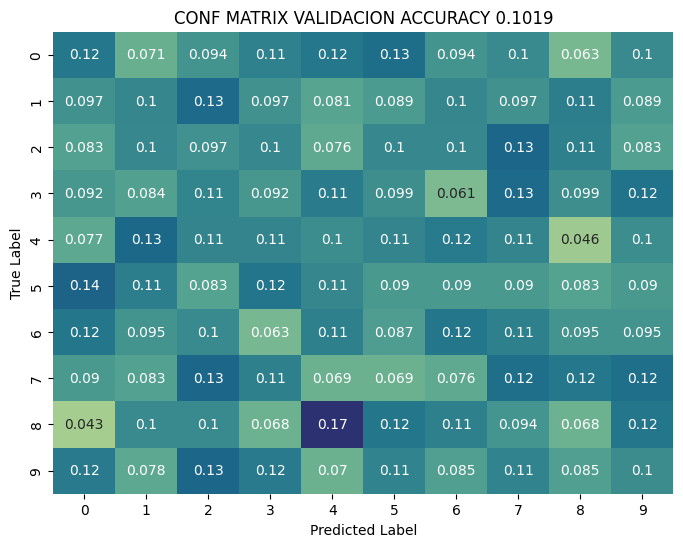

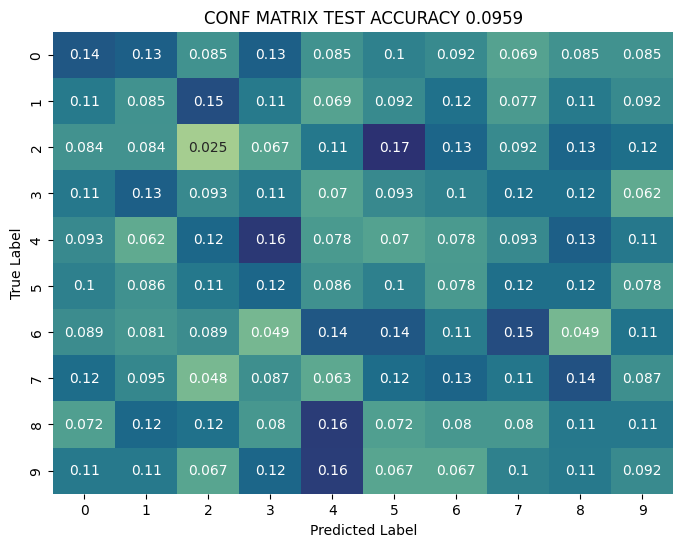



MODEL DIFFERENCES: 
ACCURACY: 0.0022988505747126436


In [25]:
# Seteo al conjunto de prueba
labels_set = {'0' : [False, True, True],
          '1' : labels_train,
          '2' : labels_val,
          '3' : labels_test}

# Busqueda del mejor accuracy normalizado
current_ba = 0
best_model = None
for result in resultados:
  current_a = result.accuracies['validacion']
  if current_a > current_ba:
    current_ba = current_a
    best_model = result

print(best_model.name)

# Guardando modelo en otro espacio de memoria
aux_model = best_model

print("RESET MODEL STARTED")

reset_model(best_model.model)

print("GETTING TEST LABELS PLOTS")

best_model_new = training(best_model.name, best_model.model,
                             torch.optim.Adam(best_model.model.parameters(), lr=1e-3),
                             1000, criterion, device,
                             labels_set, dataloaders_list)
print("MODEL DIFFERENCES: ")
print(f"ACCURACY: {abs(aux_model.accuracies['validacion'] - best_model_new.accuracies['validacion'])}")

